# Eval Metrics

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from pathlib import Path
import json
import src.config as Config
from src.models.loader import DataModule
from torch_geometric.data import HeteroData
from torch_geometric.utils import to_torch_coo_tensor
from sklearn.metrics.pairwise import cosine_similarity
import scipy.sparse as ssp 
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np


2023-03-14 00:12:56,376 - torch.distributed.nn.jit.instantiator - INFO - Created a temporary directory at /tmp/tmp7usyrodz
2023-03-14 00:12:56,378 - torch.distributed.nn.jit.instantiator - INFO - Writing /tmp/tmp7usyrodz/_remote_module_non_scriptable.py


In [4]:
# COMMON CONSTANTS
TOP_K = 20

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dm = DataModule(device)

test_user_idxs = dm.test_data['reviews'].edge_index[0]
target = to_torch_coo_tensor(
    dm.test_data["reviews"].edge_index,
    size=[dm.num_users, dm.num_recipes],
)


def test(preds_adj: torch.Tensor, test_ids = test_user_idxs):
    retrieved_and_relevant = torch.sparse.sum(preds_adj * target, dim=1).to_dense()[test_ids]
    relevant = torch.sparse.sum(target, dim=1).to_dense()[test_ids]
    retrieved = torch.sparse.sum(preds_adj, dim=1).to_dense()[test_ids]

    precision = (retrieved_and_relevant / retrieved).mean().item()
    recall = (retrieved_and_relevant / relevant).mean().item()

    return precision, recall

In [18]:
torch.isin(
    dm.test_data['reviews'].edge_index[1].unique(),
    dm.train_data['reviews'].edge_index[1].unique(),
).float().mean()

tensor(0.7887, device='cuda:0')

# Collaberative Filtering
AKA: "Wisdom of the crowd"
> For any user, recommend recipes based on what people who cook similar things are cooking

In [5]:
from surprise import KNNWithMeans, Dataset, Reader

In [6]:
tr_reviews = pd.read_parquet(
    Path(Config.PROCESSED_DATA_DIR) / 'train_review_edges.parquet',
    columns=['user_id', 'recipe_id', 'rating']
)
test_reviews = pd.read_parquet(
    Path(Config.PROCESSED_DATA_DIR) / 'test_review_edges.parquet',
    columns=['user_id', 'recipe_id', 'rating']
)

# Filter tr_reviews to only include users that are in test_reviews
tr_reviews = tr_reviews[tr_reviews['user_id'].isin(test_reviews['user_id'])]
tr_sup = Dataset.load_from_df(tr_reviews, reader=Reader(rating_scale=(0, 5))).build_full_trainset()

In [7]:
cf = KNNWithMeans(
    sim_options={
        "name": "pearson",
        "user_based": True
    }
)

cf.fit(tr_sup)

Computing the pearson similarity matrix...
Done computing similarity matrix.


In [8]:
recipe_ids = pd.concat([tr_reviews.recipe_id, test_reviews.recipe_id]).unique()
def get_top_preds_for_user(usr_id, k: int):
    preds = torch.tensor([cf.predict(usr_id, rcp_id, clip=False).est for rcp_id in recipe_ids])
    return torch.from_numpy(recipe_ids[preds.topk(k).indices])

# Only sample 200 users, else this takes 8hrs
usr_ids = test_reviews.user_id.drop_duplicates().sample(200)
preds = torch.vstack(
    [get_top_preds_for_user(x, TOP_K) for x in usr_ids]
)
preds

tensor([[223250,  35889, 281009,  ..., 177604, 106627,  85920],
        [313380, 158224,  16687,  ...,  61070,  82464,  65423],
        [223250,  35889, 281009,  ..., 177604, 106627,  85920],
        ...,
        [428760, 289404, 226542,  ...,  62891, 166623, 297987],
        [223250,  35889, 281009,  ..., 177604, 106627,  85920],
        [223250,  35889, 281009,  ..., 177604, 106627,  85920]])

In [27]:
user_ids = torch.from_numpy(usr_ids.replace(dm.user_map).to_numpy())
num_users = user_ids.shape[0]

preds_ids = torch.from_numpy(pd.DataFrame(preds.numpy()).replace(dm.recipe_map).to_numpy())

precision_k = []
recall_k = []
for k in range(1, TOP_K):
    # preds_idx = num_recipe_uses.topk(k).indices
    preds_adj = torch.sparse_coo_tensor(
        indices=torch.vstack(
            [
                user_ids[:, None]
                    .expand((num_users, k))
                    .flatten(),
                preds_ids[:, :k]
                    .expand((num_users, k))
                    .flatten(),

            ]
        ),
        values=torch.ones(num_users * k),
        size=[dm.num_users, dm.num_recipes],
        device=device,
    )
    precision, recall = test(preds_adj, user_ids)
    precision_k.append(precision)
    recall_k.append(recall)

<Axes: title={'center': 'CF: Precision@K vs Recall@K'}, xlabel='k'>

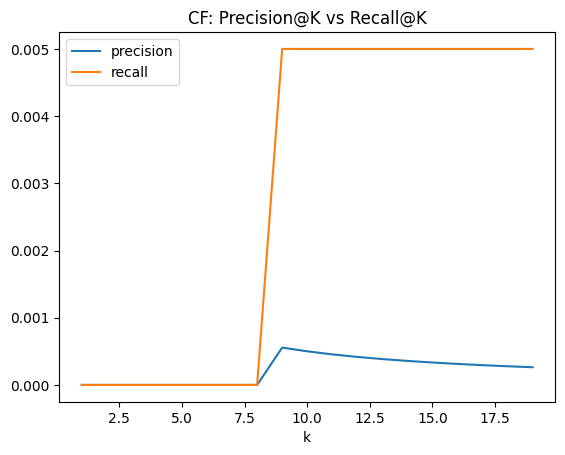

In [28]:
results_cf = pd.DataFrame({
    'k': range(1, TOP_K),
    'precision': precision_k,
    'recall': recall_k,
})
results_cf.plot(x='k', y=['precision', 'recall'], title='CF: Precision@K vs Recall@K', xlabel='k')

# GCNs

In [12]:
from src.models.lightgcn import LightGCN
from src.models.recgcn import RecGCN

In [13]:
def eval_model(model: nn.Module):
    model.to(device)
    model.eval()

    usr_out, rec_out = model(
        x_dict=dm.train_data.x_dict,
        edge_index_dict=dm.train_data.edge_index_dict,
        edge_weight_dict=dm.train_data.edge_attr_dict,
    )

    test_users = dm.test_data["reviews"].edge_index[0].unique()
    test_out = usr_out[test_users]
    num_test_users = test_users.size(0)
    batch_cutoffs = list(range(0, num_test_users, num_test_users // 20))
    batch_cutoffs.append(num_test_users)

    precision_k = []
    recall_k = []
    for k in range(1, TOP_K):
        # Need to do this in batches, otherwise we run out of memory
        recs = []
        for start, end in zip(batch_cutoffs, batch_cutoffs[1:]):
            scores = test_out[start:end] @ rec_out.T
            recs.append(scores.topk(k, dim=-1).indices)
        recs = torch.concat(recs, dim=0)
        recs = torch.sparse_coo_tensor(
            indices=torch.vstack(
                [
                    test_users[:, None]
                    .expand_as(recs)
                    .flatten(),
                    recs.flatten(),
                ]
            ),
            values=torch.ones(recs.numel()),
            size=[dm.num_users, dm.num_recipes],
            device=recs.device,
        )

        precision, recall = test(recs)
        precision_k.append(precision)
        recall_k.append(recall)
    
    return pd.DataFrame({
        'k': range(1, TOP_K),
        'precision': precision_k,
        'recall': recall_k,
    })

## Model \#1
- LightGCN
- Embed Dim = 16

In [14]:
model_path = Path(Config.MODEL_DIR) / '230313-105742'
hp = json.load((model_path / 'hp.json').open())
model = LightGCN(
    num_users=dm.num_users,
    num_recipes=dm.num_recipes,
    lambda_val=hp["lambda_val"],
    embedding_dim=hp["embed_dim"],
)
state_dict = torch.load(model_path / 'model.pt')
model.load_state_dict(state_dict)

<All keys matched successfully>

<Axes: title={'center': 'LightGCN: Precision@K vs Recall@K'}, xlabel='k'>

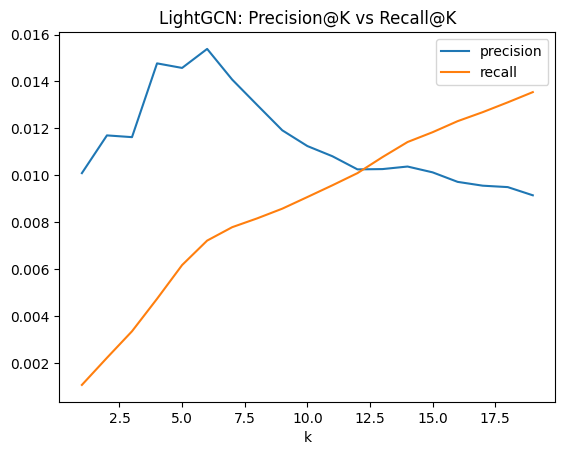

In [15]:
results1 = eval_model(model)
results1.plot(x='k', y=['precision', 'recall'], title='LightGCN: Precision@K vs Recall@K', xlabel='k')

## Model \#2
- LightGCN
- Embed Dim = 32

In [16]:
model_path = Path(Config.MODEL_DIR) / '230313-111020'
hp = json.load((model_path / 'hp.json').open())
model = LightGCN(
    num_users=dm.num_users,
    num_recipes=dm.num_recipes,
    lambda_val=hp["lambda_val"],
    embedding_dim=hp["embed_dim"],
)
state_dict = torch.load(model_path / 'model.pt')
model.load_state_dict(state_dict)

<All keys matched successfully>

<Axes: title={'center': 'LightGCN: Precision@K vs Recall@K'}, xlabel='k'>

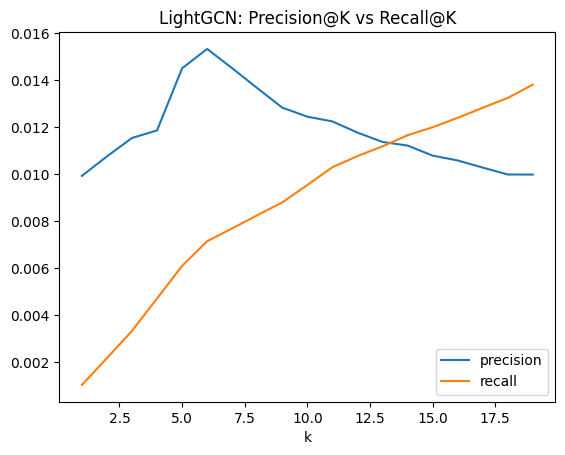

In [17]:
results2 = eval_model(model)
results2.plot(x='k', y=['precision', 'recall'], title='LightGCN: Precision@K vs Recall@K', xlabel='k')

## Model \#3
- RecGCN
- Opposite Encoding

In [18]:
model_path = Path(Config.MODEL_DIR) / '230313-110035'
hp = json.load((model_path / 'hp.json').open())
model = RecGCN(
    num_users=dm.num_users,
    num_recipes=dm.num_recipes,
    recipe_dim=dm.recipe_dim,
    lambda_val=hp["lambda_val"],
    embedding_dim=hp["embed_dim"],
    use_weights=hp["use_weights"],
    use_recipe_data=hp["use_recipe_data"],
)
state_dict = torch.load(model_path / 'model.pt')
model.load_state_dict(state_dict)

<All keys matched successfully>

<Axes: title={'center': 'LightGCN: Precision@K vs Recall@K'}, xlabel='k'>

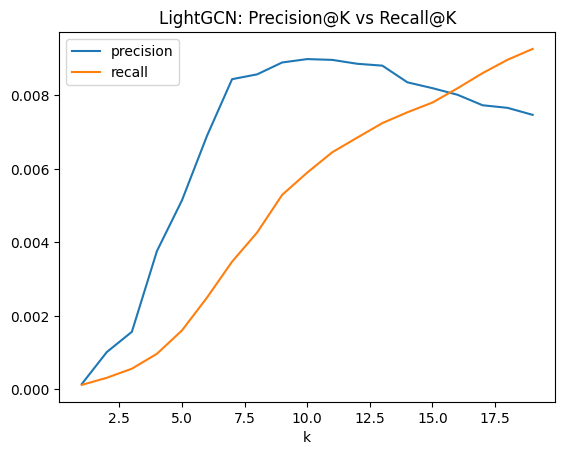

In [19]:
results3 = eval_model(model)
results3.plot(x='k', y=['precision', 'recall'], title='LightGCN: Precision@K vs Recall@K', xlabel='k')

## Model \#4
- RecGCN
- Combined Encoding

In [20]:
model_path = Path(Config.MODEL_DIR) / '230313-110406'
hp = json.load((model_path / 'hp.json').open())
model = RecGCN(
    num_users=dm.num_users,
    num_recipes=dm.num_recipes,
    recipe_dim=dm.recipe_dim,
    lambda_val=hp["lambda_val"],
    embedding_dim=hp["embed_dim"],
    use_weights=hp["use_weights"],
    use_recipe_data=hp["use_recipe_data"],
)
state_dict = torch.load(model_path / 'model.pt')
model.load_state_dict(state_dict)

<All keys matched successfully>

<Axes: title={'center': 'LightGCN: Precision@K vs Recall@K'}, xlabel='k'>

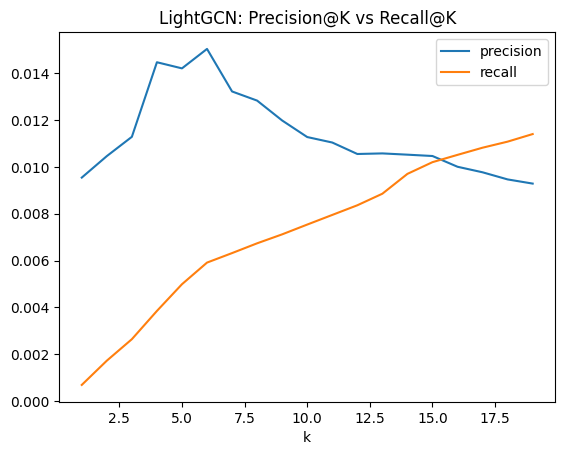

In [21]:
results4 = eval_model(model)
results4.plot(x='k', y=['precision', 'recall'], title='LightGCN: Precision@K vs Recall@K', xlabel='k')

## Model \#5
- RecGCN
- Edge Weights

In [22]:
model_path = Path(Config.MODEL_DIR) / '230313-110612'
hp = json.load((model_path / 'hp.json').open())
model = RecGCN(
    num_users=dm.num_users,
    num_recipes=dm.num_recipes,
    recipe_dim=dm.recipe_dim,
    lambda_val=hp["lambda_val"],
    embedding_dim=hp["embed_dim"],
    use_weights=hp["use_weights"],
    use_recipe_data=hp["use_recipe_data"],
)
state_dict = torch.load(model_path / 'model.pt')
model.load_state_dict(state_dict)

<All keys matched successfully>

<Axes: title={'center': 'LightGCN: Precision@K vs Recall@K'}, xlabel='k'>

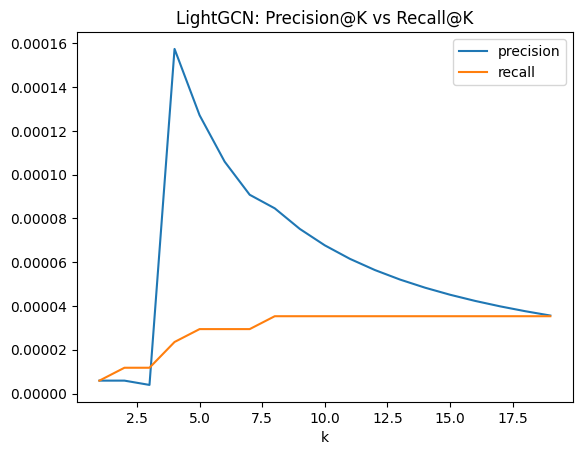

In [23]:
results5 = eval_model(model)
results5.plot(x='k', y=['precision', 'recall'], title='LightGCN: Precision@K vs Recall@K', xlabel='k')

## Model \#5
- RecGCN
- Edge Weights
- Combination

In [24]:
model_path = Path(Config.MODEL_DIR) / '230313-110649'
hp = json.load((model_path / 'hp.json').open())
model = RecGCN(
    num_users=dm.num_users,
    num_recipes=dm.num_recipes,
    recipe_dim=dm.recipe_dim,
    lambda_val=hp["lambda_val"],
    embedding_dim=hp["embed_dim"],
    use_weights=hp["use_weights"],
    use_recipe_data=hp["use_recipe_data"],
)
state_dict = torch.load(model_path / 'model.pt')
model.load_state_dict(state_dict)

<All keys matched successfully>

<Axes: title={'center': 'LightGCN: Precision@K vs Recall@K'}, xlabel='k'>

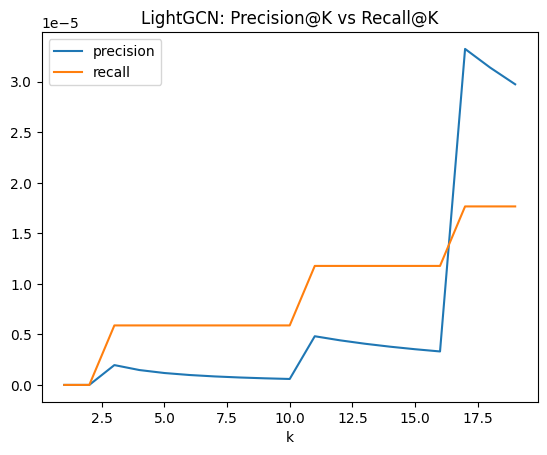

In [25]:
results6 = eval_model(model)
results6.plot(x='k', y=['precision', 'recall'], title='LightGCN: Precision@K vs Recall@K', xlabel='k')

# Final Figure Making

In [29]:
plt.rcParams['figure.figsize'] = [10, 8]

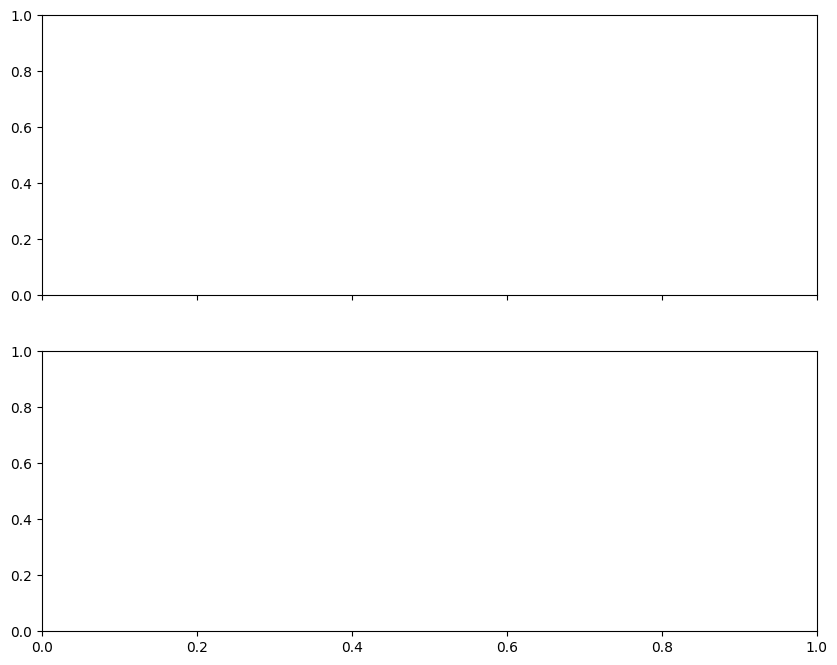

In [30]:
fig, ax = plt.subplots(2, 1, sharex=True);

## Precision

In [31]:
precision_df = pd.DataFrame({
    'k': range(1, TOP_K),
    'K-NN Collaberative Filering': results_cf.precision,
    'LightGCN (latent_dim=16)': results1.precision,
    'LightGCN (latent_dim=32)': results2.precision,
    'RecGCN (opposite_embedding)': results3.precision,
    'RecGCN (combination)': results4.precision,
}).plot(
    ax=ax[0],
    x='k',
    ylabel='Precision',
    title='Precision@K',
)

In [32]:
recall_df = pd.DataFrame({
    'k': range(1, TOP_K),
    'K-NN Collaberative Filering': results_cf.recall,
    'LightGCN (latent_dim=16)': results1.recall,
    'LightGCN (latent_dim=32)': results2.recall,
    'RecGCN (opposite_embedding)': results3.recall,
    'RecGCN (combination)': results4.recall,
}).plot(
    ax=ax[1],
    x='k',
    ylabel='Recall',
    title='Recall@K',
)

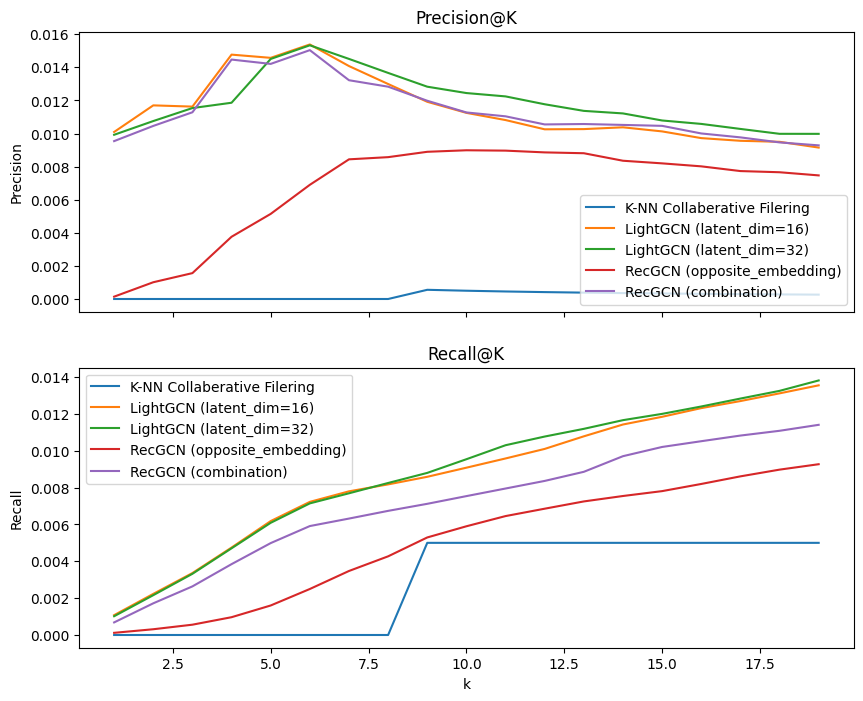

In [33]:
fig

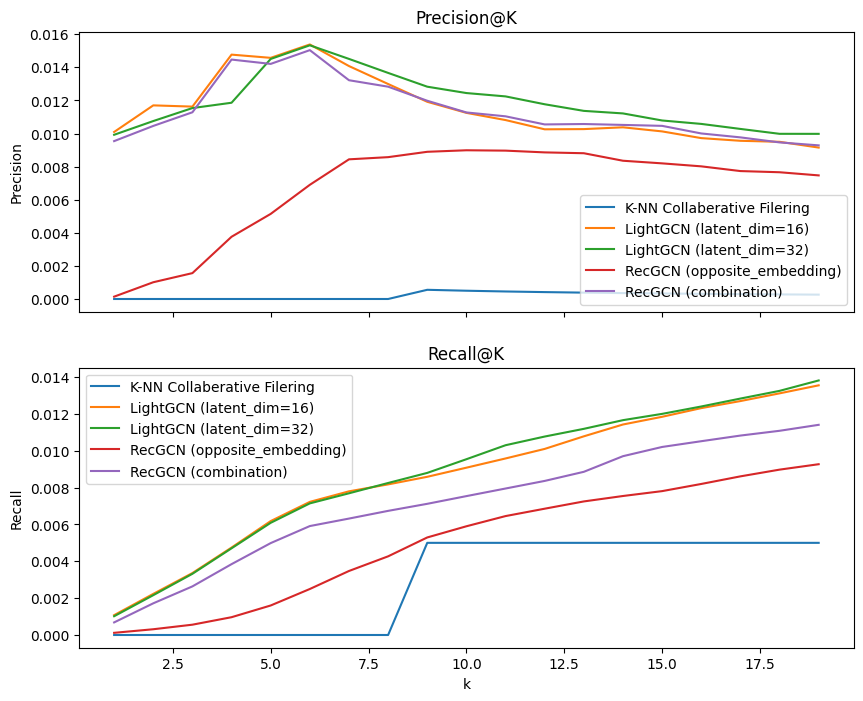

In [34]:
fig.savefig(
    '../reports/figures/model_eval.png',
    dpi=300,
    transparent=True,
    bbox_inches='tight',
)
fig

## Hyperparam

<Axes: title={'center': 'Recall@K'}, xlabel='k', ylabel='Recall'>

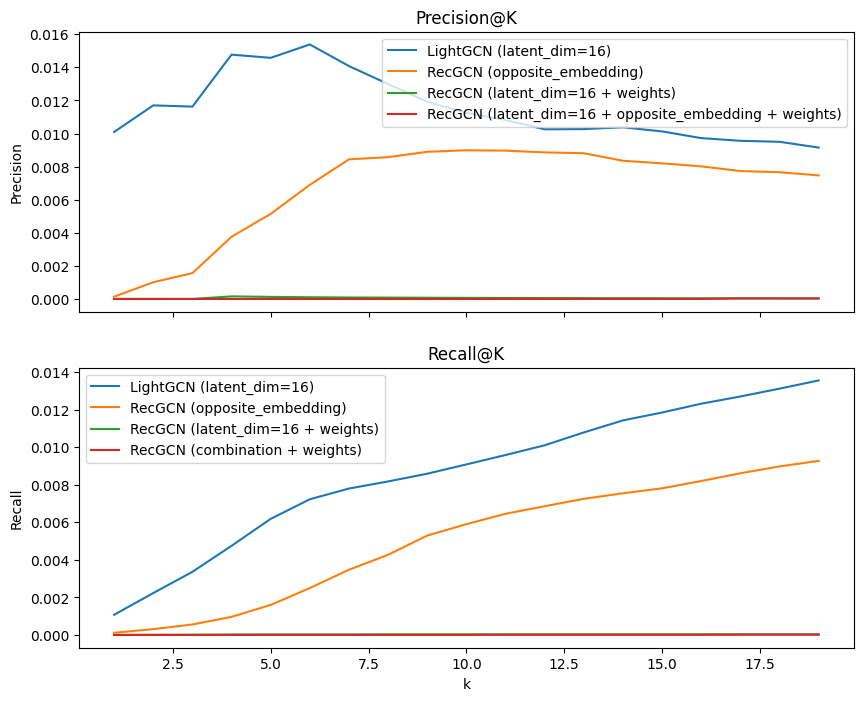

In [39]:
fig, ax = plt.subplots(2, 1, sharex=True);
pd.DataFrame({
    'k': range(1, TOP_K),
    'LightGCN (latent_dim=16)': results1.precision,
    'RecGCN (opposite_embedding)': results3.precision,
    'RecGCN (latent_dim=16 + weights)': results5.precision,
    'RecGCN (latent_dim=16 + opposite_embedding + weights)': results6.precision,
}).plot(
    ax=ax[0],
    x='k',
    ylabel='Precision',
    title='Precision@K',
)

pd.DataFrame({
    'k': range(1, TOP_K),
    'LightGCN (latent_dim=16)': results1.recall,
    'RecGCN (opposite_embedding)': results3.recall,
    'RecGCN (latent_dim=16 + weights)': results5.recall,
    'RecGCN (combination + weights)': results6.recall,
}).plot(
    ax=ax[1],
    x='k',
    ylabel='Recall',
    title='Recall@K',
)

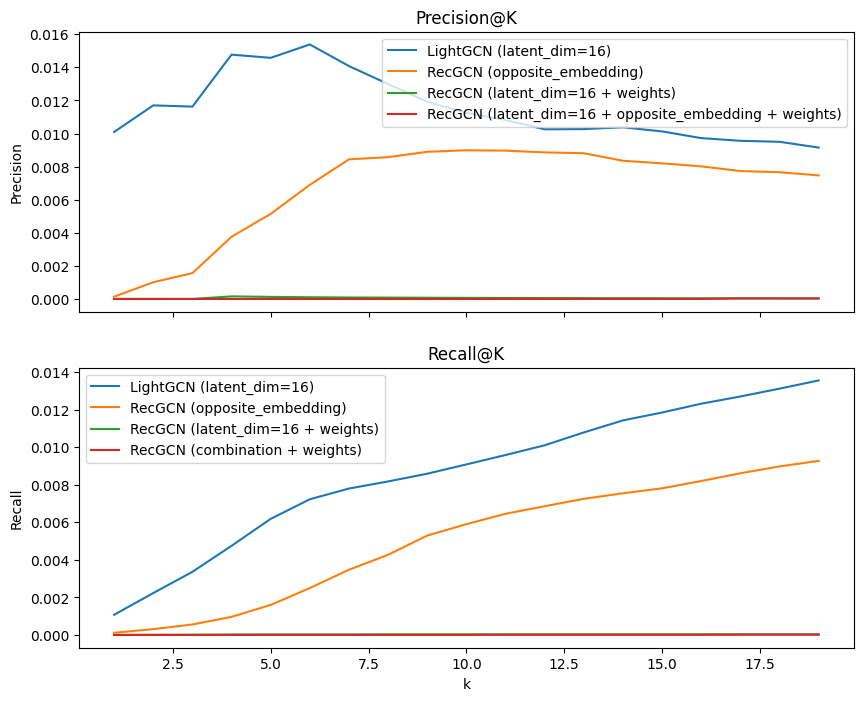

In [40]:
fig.savefig(
    '../reports/figures/flag_eval.png',
    dpi=300,
    transparent=True,
    bbox_inches='tight',
)
fig